In [2]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [3]:
!unzip -q archive.zip -d brain_tumor_dataset


In [4]:
import os
os.listdir('brain_tumor_dataset')


['no', 'brain_tumor_dataset', 'yes']

In [5]:
import os

base_path = "brain_tumor_dataset"

# Check subfolders
classes = os.listdir(base_path)
print("Classes:", classes)

# Count images per class
for cls in classes:
    count = len(os.listdir(os.path.join(base_path, cls)))
    print(f"{cls}: {count} images")


Classes: ['no', 'brain_tumor_dataset', 'yes']
no: 98 images
brain_tumor_dataset: 2 images
yes: 155 images


In [6]:
import shutil

extra_path = os.path.join(base_path, "brain_tumor_dataset")
if os.path.exists(extra_path):
    shutil.rmtree(extra_path)
    print("Removed extra folder:", extra_path)


Removed extra folder: brain_tumor_dataset/brain_tumor_dataset


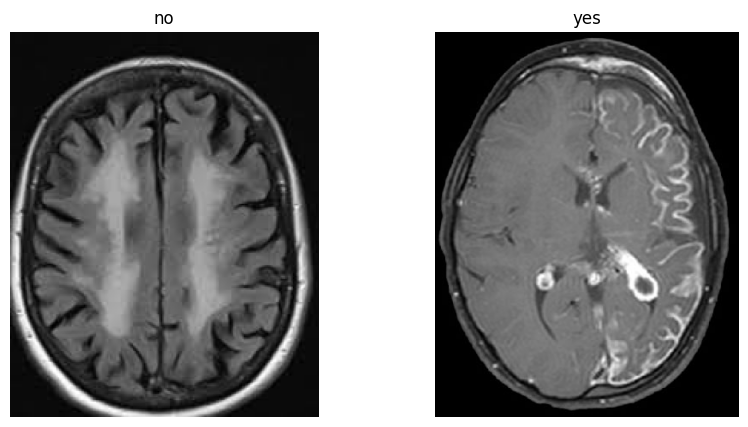

In [7]:
import matplotlib.pyplot as plt
import cv2
import random

plt.figure(figsize=(10, 5))

for i, category in enumerate(['no', 'yes']):
    folder = os.path.join(base_path, category)
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')

plt.show()


In [8]:
import os, shutil, random

src_root = 'brain_tumor_dataset'
target_root = 'data'
os.makedirs(target_root, exist_ok=True)

for subset in ['train', 'val', 'test']:
    for cls in ['yes', 'no']:
        os.makedirs(f'{target_root}/{subset}/{cls}', exist_ok=True)

split_ratios = {'train':0.8, 'val':0.1, 'test':0.1}

for cls in ['yes','no']:
    files = os.listdir(f'{src_root}/{cls}')
    random.shuffle(files)
    n_total = len(files)
    n_train = int(split_ratios['train'] * n_total)
    n_val   = int(split_ratios['val'] * n_total)

    for i, f in enumerate(files):
        src = f'{src_root}/{cls}/{f}'
        if i < n_train:
            dst = f'{target_root}/train/{cls}/{f}'
        elif i < n_train + n_val:
            dst = f'{target_root}/val/{cls}/{f}'
        else:
            dst = f'{target_root}/test/{cls}/{f}'
        shutil.copy(src, dst)


In [9]:
for subset in ['train','val','test']:
    print(subset, '-> yes:', len(os.listdir(f'data/{subset}/yes')),
          ' no:', len(os.listdir(f'data/{subset}/no')))


train -> yes: 124  no: 78
val -> yes: 15  no: 9
test -> yes: 16  no: 11


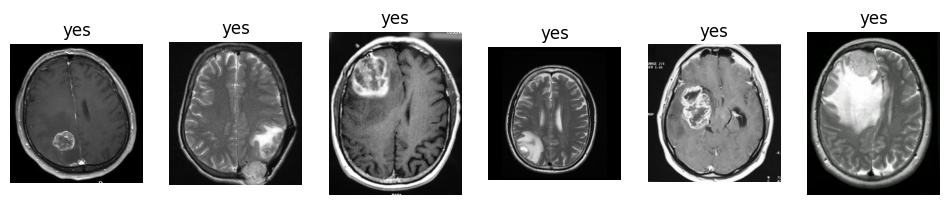

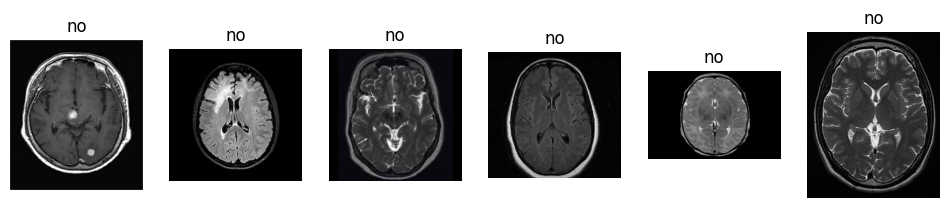

In [10]:
import matplotlib.pyplot as plt
import random
from PIL import Image

def show_samples(folder, n=6):
    files = os.listdir(folder)
    chosen = random.sample(files, min(n, len(files)))
    plt.figure(figsize=(12,4))
    for i,f in enumerate(chosen):
        img = Image.open(os.path.join(folder, f))
        plt.subplot(1,n,i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(folder))
    plt.show()

show_samples('data/train/yes')
show_samples('data/train/no')


In [11]:
import os
import shutil
from sklearn.model_selection import train_test_split

base_dir = 'brain_tumor_dataset'
classes = ['no', 'yes']

# Create output directories
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(split, cls), exist_ok=True)

# Split and move files
for cls in classes:
    src = os.path.join(base_dir, cls)
    all_images = os.listdir(src)

    train_files, temp_files = train_test_split(all_images, test_size=0.25, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    for f in train_files:
        shutil.copy(os.path.join(src, f), os.path.join('train', cls))
    for f in val_files:
        shutil.copy(os.path.join(src, f), os.path.join('val', cls))
    for f in test_files:
        shutil.copy(os.path.join(src, f), os.path.join('test', cls))

print("✅ Dataset successfully split into train, val, and test folders!")


✅ Dataset successfully split into train, val, and test folders!


In [12]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions
IMG_SIZE = (128, 128)

# Preprocessing setup
train_datagen = ImageDataGenerator(
    rescale=1./255,           # normalize
    rotation_range=15,        # rotate slightly
    width_shift_range=0.1,    # horizontal shift
    height_shift_range=0.1,   # vertical shift
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,     # flip horizontally
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    'val',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 189 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 33 images belonging to 2 classes.


In [13]:
import os
print(os.getcwd())
print(os.listdir())



/content
['.config', 'archive.zip', 'data', 'train', 'brain_tumor_dataset', 'test', 'val', 'sample_data']


In [14]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

IMG_SIZE = (128, 128)
base_dir = 'brain_tumor_dataset'
classes = ['no', 'yes']

X = []
y = []

for label, cls in enumerate(classes):
    folder = os.path.join(base_dir, cls)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            X.append(img.flatten())   # flatten into vector
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Data shape:", X.shape)


Data shape: (253, 16384)


In [15]:
#split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [16]:
#Train classical models
#k-nearest neighbour
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


KNN Accuracy: 0.6875
[[19  5]
 [15 25]]
              precision    recall  f1-score   support

           0       0.56      0.79      0.66        24
           1       0.83      0.62      0.71        40

    accuracy                           0.69        64
   macro avg       0.70      0.71      0.68        64
weighted avg       0.73      0.69      0.69        64



In [17]:
#Support vector machine
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.796875
[[17  7]
 [ 6 34]]
              precision    recall  f1-score   support

           0       0.74      0.71      0.72        24
           1       0.83      0.85      0.84        40

    accuracy                           0.80        64
   macro avg       0.78      0.78      0.78        64
weighted avg       0.80      0.80      0.80        64



In [18]:
#decision tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))


Decision Tree Accuracy: 0.75
[[18  6]
 [10 30]]
              precision    recall  f1-score   support

           0       0.64      0.75      0.69        24
           1       0.83      0.75      0.79        40

    accuracy                           0.75        64
   macro avg       0.74      0.75      0.74        64
weighted avg       0.76      0.75      0.75        64



In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    'train',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    'val',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    'test',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 189 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 33 images belonging to 2 classes.


In [20]:
#a simple CNN
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # binary output
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5873 - loss: 0.9517 - val_accuracy: 0.7742 - val_loss: 0.6805
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6128 - loss: 0.6749 - val_accuracy: 0.6774 - val_loss: 0.5899
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 994ms/step - accuracy: 0.6669 - loss: 0.5984 - val_accuracy: 0.7097 - val_loss: 0.5659
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6962 - loss: 0.5909 - val_accuracy: 0.8065 - val_loss: 0.5063
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7226 - loss: 0.5779 - val_accuracy: 0.7742 - val_loss: 0.5002
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6693 - loss: 0.5844 - val_accuracy: 0.8065 - val_loss: 0.4861
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7769 - loss: 0.5593 - val_accuracy: 0.8065 - val_loss: 0.4800
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7477 - loss: 0.5578 - val_accuracy: 0.7742 - val_loss: 0.4763
Epoch 9/15
6

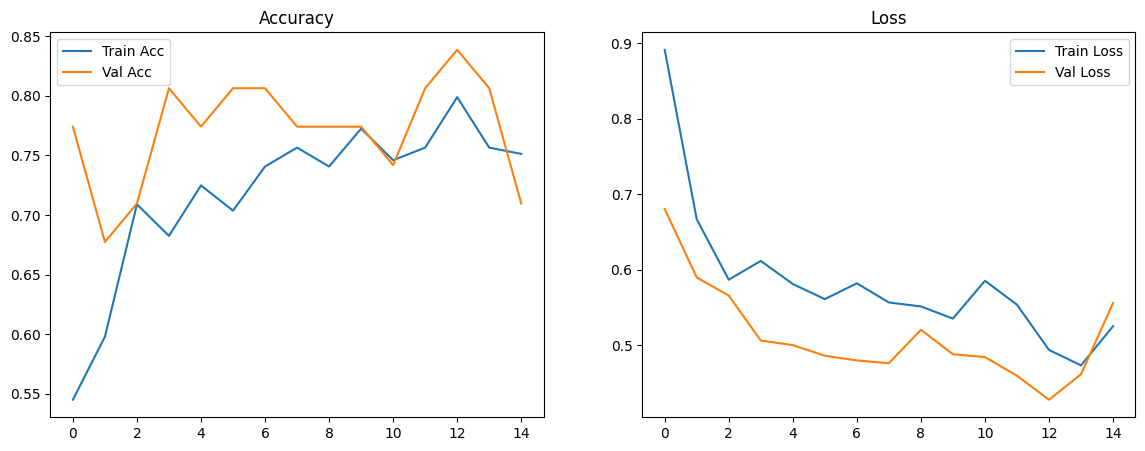

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [23]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7857 - loss: 0.4300 
Test Accuracy: 0.7878788113594055


In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(test_gen)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(test_gen.classes, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(test_gen.classes, y_pred, target_names=['No Tumor', 'Tumor']))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Confusion Matrix:
 [[10  3]
 [ 4 16]]

Classification Report:

              precision    recall  f1-score   support

    No Tumor       0.71      0.77      0.74        13
       Tumor       0.84      0.80      0.82        20

    accuracy                           0.79        33
   macro avg       0.78      0.78      0.78        33
weighted avg       0.79      0.79      0.79        33



In [25]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False  # freeze layers


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model_tl = Model(inputs=base_model.input, outputs=output)


In [27]:
model_tl.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [28]:
history_tl = model_tl.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4839 - loss: 1.0411 - val_accuracy: 0.6129 - val_loss: 0.6153
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 594ms/step - accuracy: 0.7663 - loss: 0.5288 - val_accuracy: 0.7419 - val_loss: 0.4538
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 762ms/step - accuracy: 0.7992 - loss: 0.4401 - val_accuracy: 0.8710 - val_loss: 0.3372
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - accuracy: 0.8209 - loss: 0.3859 - val_accuracy: 0.9355 - val_loss: 0.2647
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - accuracy: 0.8806 - loss: 0.3042 - val_accuracy: 0.9355 - val_loss: 0.2258
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 770ms/step - accuracy: 0.9092 - loss: 0.2782 - val_accuracy: 0.9032 - val_loss: 0.2182
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.9082 - loss: 0.2756 - val_accuracy: 0.9355 - val_loss: 0.2129
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 548ms/step - accuracy: 0.9295 - loss: 0.2082 - val_accuracy: 0.9355 - val_loss: 0

In [29]:
test_loss, test_acc = model_tl.evaluate(test_gen)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8469 - loss: 0.3197
Test Accuracy: 0.8484848737716675
Test Loss: 0.316518634557724


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step


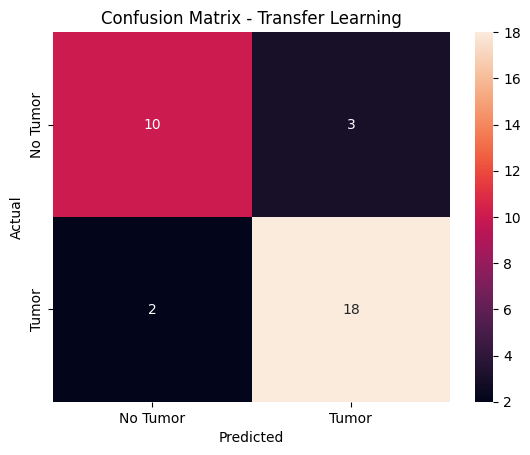

Classification Report:

              precision    recall  f1-score   support

    No Tumor       0.83      0.77      0.80        13
       Tumor       0.86      0.90      0.88        20

    accuracy                           0.85        33
   macro avg       0.85      0.83      0.84        33
weighted avg       0.85      0.85      0.85        33



In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = model_tl.predict(test_gen)
y_pred = (y_pred > 0.5).astype(int)

# True labels
y_true = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Transfer Learning')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))


In [31]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt


In [32]:
img, label = test_gen[0]
img = img[0]   # take first image from batch
input_img = np.expand_dims(img, axis=0)


In [38]:
last_conv_layer_name = "Conv_1"


In [42]:
def make_gradcam_heatmap(img_array, model, last_conv_layer):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()


In [40]:
heatmap = make_gradcam_heatmap(input_img, model_tl, last_conv_layer_name)


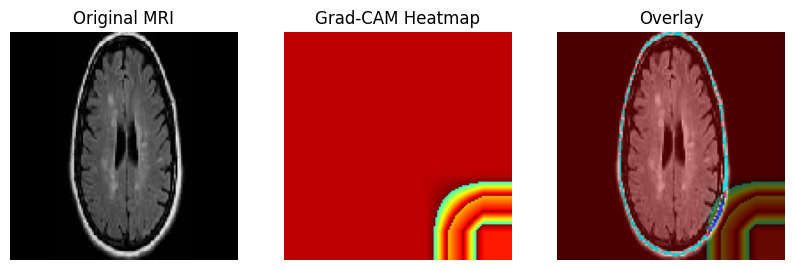

In [46]:
heatmap = cv2.resize(heatmap, (128,128))
heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img * 255

plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Original MRI")
plt.imshow(img)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(superimposed_img.astype('uint8'))
plt.axis('off')

plt.show()


In [43]:
for layer in model_tl.layers:
    print(layer.name)


input_layer_1
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_

In [48]:
from google.colab import files
files.download("brain_tumor_detection.ipynb")   # replace with the exact file name


FileNotFoundError: Cannot find file: brain_tumor_detection.ipynb

In [49]:
import os
os.listdir()


['.config',
 'archive.zip',
 'data',
 'train',
 'brain_tumor_dataset',
 'test',
 'val',
 'sample_data']

In [50]:
from google.colab import files
files.download("archive.zip")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>